In [1]:
from pathlib import Path
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
import seaborn as sns
sns.set();
from tqdm import tqdm_notebook as tqdm
from scipy.stats import wilcoxon
from statsmodels.stats.weightstats import ttost_ind

from dpipe.io import load
from damri.utils import choose_root

In [2]:
meta_path = 'path/to/cc359/meta.csv'
meta = pd.read_csv('/gpfs/data/gpfs0/b.shirokikh/data/cc359/meta.csv', index_col='id')
meta.head()

,MRI,brain_mask,fold,tomograph_model,tesla_value,x,y,z
id,,,,,,,,
CC0030,images/CC0030_philips_15_42_F.nii.gz,masks/CC0030_philips_15_42_F_ss.nii.gz,4,philips,15,1.000008,0.888889,0.888889
CC0326,images/CC0326_ge_3_55_M.nii.gz,masks/CC0326_ge_3_55_M_ss.nii.gz,3,ge,3,1.000000,1.000000,1.000000
CC0187,images/CC0187_siemens_3_63_F.nii.gz,masks/CC0187_siemens_3_63_F_ss.nii.gz,1,siemens,3,1.329996,1.000000,1.000000
CC0114,images/CC0114_philips_3_60_M.nii.gz,masks/CC0114_philips_3_60_M_ss.nii.gz,5,philips,3,1.000000,1.000000,1.000000
CC0231,images/CC0231_siemens_3_56_M.nii.gz,masks/CC0231_siemens_3_56_M_ss.nii.gz,1,siemens,3,1.330005,1.000000,1.000000


In [3]:
exp_oracle = Path('path/to/experiment/cc359_unet2d_oracle/')
exp_base = Path('path/to/experiment/cc359_unet2d_one2all/')

exp_stack_base = Path('path/to/experiments/stack/with/unfreeze_first/and/posttrain/')
exp_stack_spottune = Path('path/to/experiments/stack/with/spottune/')
n2folder = {'1/36': '1_36', '1/24': '1_24', '1/12': '1_12', '1/6': '1_6', '1/3': '1_3',
            '1': '1', '3': '3'}
n2label = {'1/36': '8', '1/24': '12', '1/12': '24', '1/6': '45', '1/3': '90',
            '1': '270', '3': '800'}

In [4]:
groups = list(n2folder.keys())

exps = ['posttrain', 'unfreeze_first', 'spottune']
exp2label = {e: l for e, l in zip(exps, ['Fine-tune All Layers', 'Fine-tune First Layers', 'SpotTUnet'])}
exp2color = {e: c for e, c in zip(exps, ['#2274A5', '#FFBF00', '#E83F6F'])}

In [5]:
def load_dice_stack_base(n, n_folds=6):
    stack = []
    for i in range(n_folds):
        dices = load(exp_base / f'experiment_{i}/test_metrics/sdice_score.json')
        for j in range(n_folds - 1):
            pair_ids = sorted(list(load(exp_stack_base /
                f'{n2folder[n]}/posttrain/experiment_{i * (n_folds - 1) + j}/test_metrics/sdice_score.json'
            ).keys()))
            stack.append(np.array([dices[_id] for _id in pair_ids]))
    return stack

d_base = {n: {e: load_dice_stack_base(n) for e in exps} for n in groups}

In [6]:
def load_dice_stack_oracle(n, n_folds=6):
    stack = []
    for i, i_cv in enumerate([i for f in range(n_folds) for i in set(range(6)) - {f}]):
        dices = {}
        for j in range(3):
            dices = {**dices, **load(exp_oracle / f'experiment_{i_cv * 3 + j}/test_metrics/sdice_score.json')}
        pair_ids = sorted(list(load(exp_stack_base /
            f'{n2folder[n]}/posttrain/experiment_{i}/test_metrics/sdice_score.json'
        ).keys()))
        stack.append(np.array([dices[_id] for _id in pair_ids]))
    return stack

d_oracle = {n: {e: load_dice_stack_oracle(n) for e in exps} for n in groups}

In [7]:
def load_dice_stack(exp, n, n_folds=6):
    if exp == 'spottune':
        path = str(exp_stack_spottune / n2folder[n] / 'opt_k/experiment_{}/test_metrics/sdice_score.json')
    else:  # 'posttrain' or 'unfreeze_first'
        path = str(exp_stack_base / n2folder[n] / exp / 'experiment_{}/test_metrics/sdice_score.json')
        
    stack = []
    for i in range(n_folds * (n_folds - 1)):
        dices = load(path.format(i))
        stack.append(np.array([dices[_id] for _id in sorted(list(dices.keys()))]))
    return stack

d = {n: {e: load_dice_stack(e, n) for e in exps} for n in groups}

In [8]:
d_means = {n: {e: [np.mean(arr) for arr in d[n][e]] for e in exps} for n in groups}
d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]] for e in exps} for n in groups}
d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]] for e in exps} for n in groups}

In [9]:
d_rel = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d[n][e], d_base[n][e], d_oracle[n][e])]
                for e in exps
            }
            for n in groups
        }

In [10]:
d_rel_means = {n: 
            {e: 
                [(s1 - s2) / (s3 - s2) for s1, s2, s3 in 
                 zip(d_means[n][e], d_base_means[n][e], d_oracle_means[n][e])]
                for e in exps
            }
            for n in groups
        }

In [11]:
# remove validation:
n_first_val = 5
d_means = {n: {e: [np.mean(arr) for arr in d[n][e]][n_first_val:] for e in exps} for n in groups}
d_base_means = {n: {e: [np.mean(arr) for arr in d_base[n][e]][n_first_val:] for e in exps} for n in groups}
d_oracle_means = {n: {e: [np.mean(arr) for arr in d_oracle[n][e]][n_first_val:] for e in exps} for n in groups}

In [12]:
df_to_vis = []
i = 0
for n in groups:
    sdict = d_means[n]
    for e in exps:
        arr = sdict[e]
        for sdsc in arr:
            df_to_vis.append({'id': i, 'n_data': n2label[n], 'sdsc': sdsc, 'exp': exp2label[e]})
            i += 1
df_to_vis = pd.DataFrame.from_records(df_to_vis, index='id')

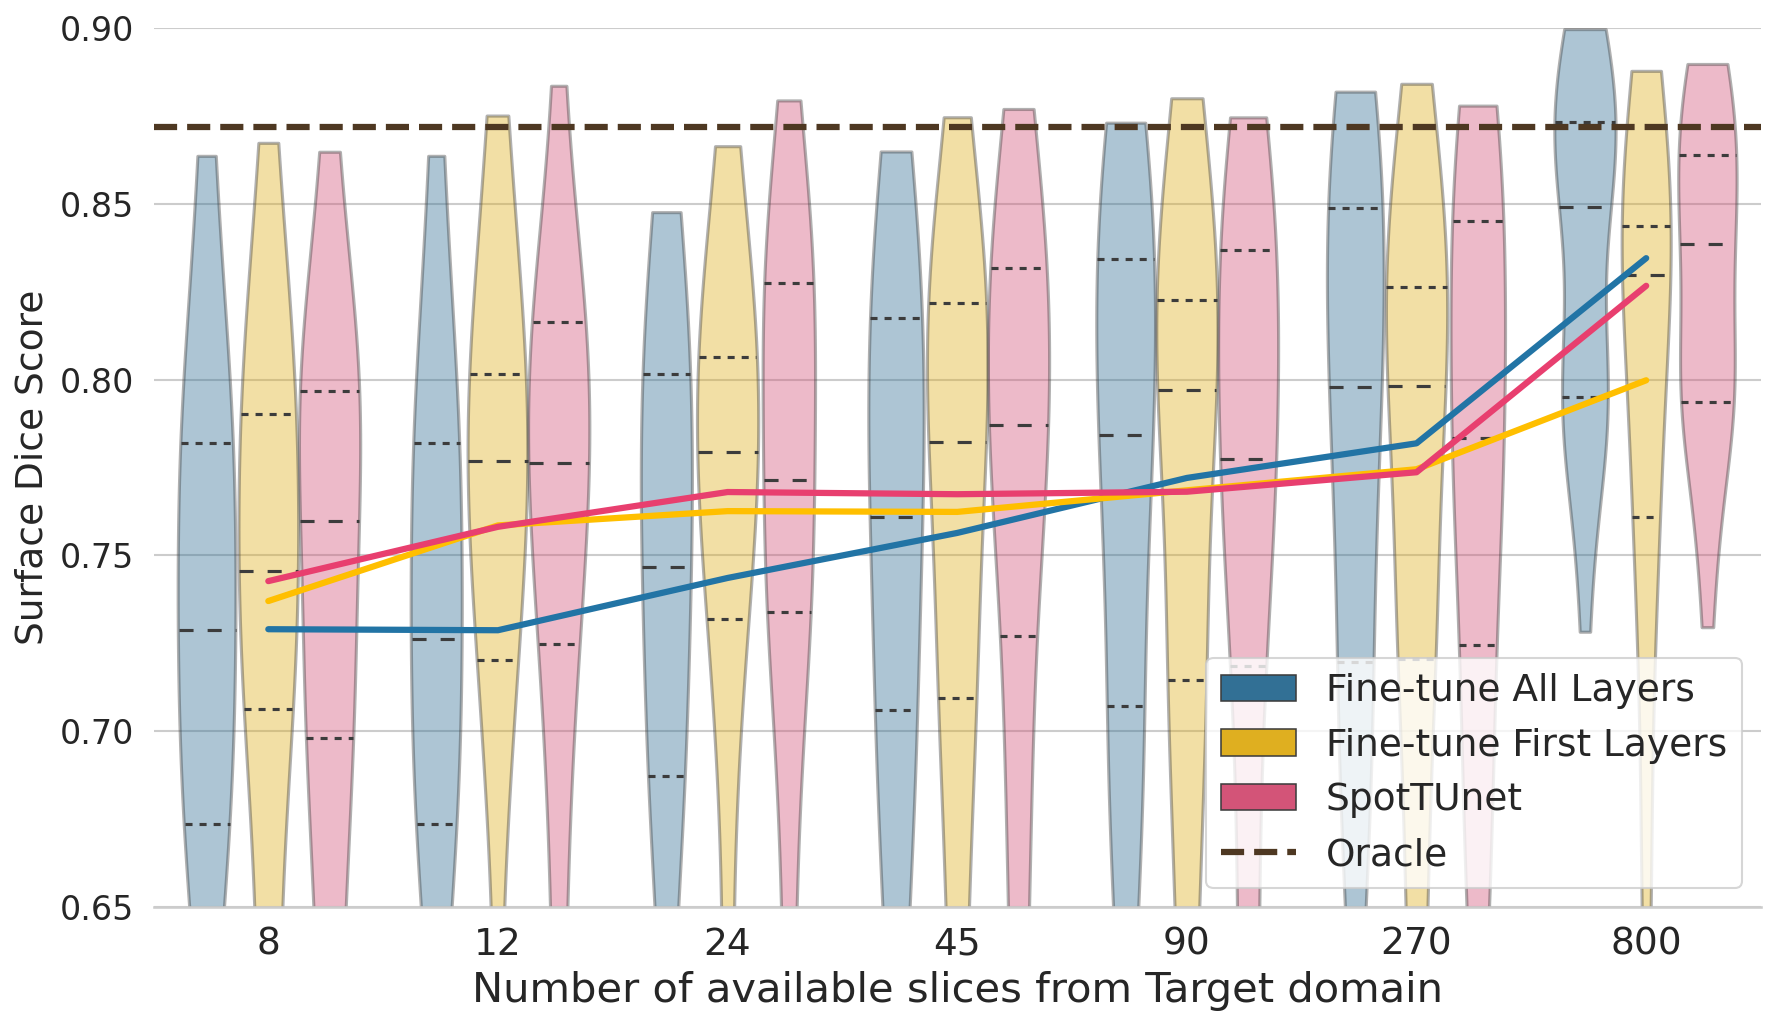

In [13]:
sns.set(style="whitegrid", palette="pastel", color_codes=True);
# sns.set(palette="pastel", color_codes=True);

fig, ax = plt.subplots(figsize=(12, 7), dpi=150)

sns.violinplot(x='n_data', y='sdsc', hue='exp', inner='quart', data=df_to_vis, cut=0,
               palette={e: c for e, c in zip(exp2label.values(), exp2color.values())})
sns.despine(left=True)

plt.setp(ax.collections, alpha=.4)

plt.ylim((0.65, 0.9))

# plt.ylabel('delta (transfering) / delta (oracle)', fontsize=18)
ax = plt.gca()
ax.set_ylabel('Surface Dice Score', fontsize=18)

# plt.xlabel('# of images to train on', fontsize=20)
ax.set_xlabel('Number of available slices from Target domain', fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)

for e in exps:
    arr = np.array([np.mean(d_means[n][e]) for n in groups])
    plt.plot(np.arange(len(groups)), arr, color=exp2color[e], linewidth=3)
    
global_mean_b = np.mean(d_base_means['1']['spottune'])
global_mean_o = np.mean(d_oracle_means['1']['spottune'])
# plt.plot(np.arange(len(groups)), [global_mean_b] * len(groups), color='black', linewidth=5)
# plt.plot(np.arange(len(groups)), [global_mean_o] * len(groups), color='black', linewidth=2, linestyle='--')

plt.hlines(global_mean_o, -0.5, len(groups), colors='#4E3822', linestyle='--', linewidth=3)
plt.xlim((-0.5, len(groups) - 0.5))

handles, labels = ax.get_legend_handles_labels()
line_oracle = Line2D([0], [0], color='#4E3822', linewidth=3, linestyle='--', label='Oracle')
handles.append(line_oracle)
plt.legend(handles=handles, loc='lower right', fontsize=18)
    
# plt.xticks(ticks=np.arange(len(d)), labels=list(n2folder.keys()))

plt.tight_layout()
plt.show()

### Case-wise statistical analysis

In [17]:
d_means_test = {n: {e: [i for arr in d[n][e][n_first_val:] for i in arr] for e in exps} for n in groups}

In [18]:
df_to_test = []
i = 0
for n in groups:
    sdict = d_means_test[n]
    for e in exps:
        arr = sdict[e]
        for sdsc in arr:
            df_to_test.append({'id': i, 'n_data': n2label[n], 'sdsc': sdsc, 'exp': exp2label[e]})
            i += 1
df_to_test = pd.DataFrame.from_records(df_to_test, index='id')

In [20]:
for _data in list(n2label.values()):
    _df = df_to_test[df_to_test['n_data'] == _data]
    
    spottune_res = _df[_df['exp'] == 'SpotTUnet']['sdsc'].values
    
    first_res = _df[_df['exp'] == 'Fine-tune First Layers']['sdsc'].values
    all_res = _df[_df['exp'] == 'Fine-tune All Layers']['sdsc'].values
    
    best_res = first_res if np.mean(first_res) > np.mean(all_res) else all_res
    
    pv_w = wilcoxon(spottune_res - best_res, alternative='greater')[-1]
    if pv_w < 0.05:
        print(f'{_data} slices available: P-value (Wilcoxon) = {pv_w:.4f}')
    else:
        avg_std = 0.5 * (np.std(spottune_res) + np.std(best_res))
        eps = 0.25 * avg_std
        pv_tost = ttost_ind(spottune_res, best_res, -eps, eps)[0]
        print(f'{_data} slices available: P-value (TOST) = {pv_tost:.4f}')

8 slices available: P-value (Wilcoxon) = 0.0000
12 slices available: P-value (Wilcoxon) = 0.0004
24 slices available: P-value (Wilcoxon) = 0.0000
45 slices available: P-value (Wilcoxon) = 0.0000
90 slices available: P-value (TOST) = 0.0000
270 slices available: P-value (TOST) = 0.0000
800 slices available: P-value (TOST) = 0.0000


### Fold-wise statistical analysis

In [14]:
for _data in list(n2label.values()):
    _df = df_to_vis[df_to_vis['n_data'] == _data]
    
    spottune_res = _df[_df['exp'] == 'SpotTUnet']['sdsc'].values
    
    first_res = _df[_df['exp'] == 'Fine-tune First Layers']['sdsc'].values
    all_res = _df[_df['exp'] == 'Fine-tune All Layers']['sdsc'].values
    
    best_res = first_res if np.mean(first_res) > np.mean(all_res) else all_res
    
    pv_w = wilcoxon(spottune_res - best_res, alternative='greater')[-1]
    if pv_w < 0.05:
        print(f'{_data} slices available: P-value (Wilcoxon) = {pv_w:.4f}')
    else:
        avg_std = 0.5 * (np.std(spottune_res) + np.std(best_res))
        eps = 0.5 * avg_std
        pv_tost = ttost_ind(spottune_res, best_res, -eps, eps)[0]
        print(f'{_data} slices available: P-value (TOST) = {pv_tost:.4f}')

8 slices available: P-value (TOST) = 0.0754
12 slices available: P-value (TOST) = 0.0466
24 slices available: P-value (Wilcoxon) = 0.0452
45 slices available: P-value (TOST) = 0.0707
90 slices available: P-value (TOST) = 0.0635
270 slices available: P-value (TOST) = 0.0899
800 slices available: P-value (TOST) = 0.1307


P-value of one-sided Wilcoxon signed-rank test indicates the superior performance of SpotTUnet.

P-value of the TOST (two one-sided T-test) indicates the equal performance of SpotTUnet and the best of the "Fine-tune All Layers" and "Fine-tune First Layers" methods.

Despite not all of the equivalence tests pass the 5% significance level, we have a clear pattern of the distributions closeness.